For pre-processing TMS/iEEG data stored across files

In [1]:
import mne
import matlab.engine
import numpy as np
import pandas as pd
import pylab as plt
from codebase import matlabToPython

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

In [2]:
#Load the data
fname_sham = './TMSEEG_data/561/561_Sham_DLPFC_0_5Hz_1-CleanedFilteredSubsampled.npy'
fname_tms = './TMSEEG_data/561/561_TMS_DLPFC_0_5Hz_1-CleanedFilteredSubsampled.npy'

eng = matlab.engine.start_matlab()  #start the MATLAB engine
content_sham = eng.load(fname_sham, nargout=1)
content_tms = eng.load(fname_tms, nargout=1)
#elecs = matlabToPython(eng, content_sham, 'channelInfo')  #Import from .mat files -- does appear that channelInfo is the same between sham/TMS trials but always good to double check


MatlabExecutionError: Unable to read file './TMSEEG_data/561/561_Sham_DLPFC_0_5Hz_1-CleanedFilteredSubsampled.npy'. Input must be a MAT-file or an ASCII file containing numeric data with same number of columns in each row.


In [3]:
#Load the EEG data
eeg_sham = np.array(content_sham['ftData']['trial'][0])
eeg_tms = np.array(content_tms['ftData']['trial'][0])

#Trigger data (when stim/sham events occur, in seconds)
trigTimes_sham = np.array(content_sham['trigTimes'])[0]
trigLens_sham = np.array(content_sham['trigLengths'])[0]
trigTimes_tms = np.array(content_tms['trigTimes'])[0]
trigLens_tms = np.array(content_tms['trigLengths'])[0]

#figure out downsample factor (checks between files)
fs = 500
dsample_sham = int(content_sham['ftData']['fsample']/fs) 
dsample_tms = int(content_tms['ftData']['fsample']/fs) 
if dsample_sham!=dsample_tms:
    raise ValueError
    print('Sampling rate does not match between sham and TMS files!')
else:
    dsample = dsample_sham

NameError: name 'content_sham' is not defined

In [5]:
# Filter out line noise
eeg_tms_filt = mne.filter.notch_filter(eeg_tms, Fs=content_sham['ftData']['fsample'], freqs=[60, 120, 180],
                                    method='spectrum_fit', n_jobs=n_cpus, verbose=False)
eeg_sham_filt = mne.filter.notch_filter(eeg_sham, Fs=content_sham['ftData']['fsample'], freqs=[60, 120, 180],
                                    method='spectrum_fit', n_jobs=n_cpus, verbose=False)

# Resample the data (should we do this before or after filtering line noise?)
eeg_tms_rs = mne.filter.resample(eeg_tms_filt, down=dsample, n_jobs=n_cpus)
eeg_sham_rs = mne.filter.resample(eeg_sham_filt, down=dsample, n_jobs=n_cpus)

#Low-pass filter for the ERP analysis, not spectral
#eeg_tms_filt_lp = mne.filter.filter_data(eeg_tms_filt, sfreq=fs, l_freq=None, h_freq=35, verbose=False, n_jobs=n_cpus)
#eeg_sham_filt_lp = mne.filter.filter_data(eeg_sham_filt, sfreq=fs, l_freq=None, h_freq=35, verbose=False, n_jobs=n_cpus)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 120 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    3.6s finished


In [6]:
# Convert trigTimes to samples
trigTimes_sham_samp = (trigTimes_sham*fs).astype(int)
trigTimes_tms_samp = (trigTimes_tms*fs).astype(int)

#Plot triggered evoked potential
sep_sham = []
for idx in trigTimes_sham_samp:
    sep_sham.append(eeg_sham_rs[:, int(idx-(fs/1)):int(idx+(fs*2))])  #getting 1000ms prior to stim until 2 seconds after stim
sep_sham = np.array(sep_sham)

sep_tms = []
for idx in trigTimes_tms_samp:
    sep_tms.append(eeg_tms_rs[:, int(idx-(fs/1)):int(idx+(fs*2))])
sep_tms = np.array(sep_tms)

In [7]:
#Save the filtered and resampled data
np.save('./TMSEEG_data/405/405_Sham_Parietal_0_5Hz_1-CleanedFilteredSubsampled_3sec.npy', sep_sham)
np.save('./TMSEEG_data/405/405_TMS_Parietal_0_5Hz_1-CleanedFilteredSubsampled_3sec.npy', sep_tms)

#elecs.to_pickle('./TMSEEG_data/534/534_DLPFC_elecs.pkl')

## Get stimulation evoked potentials (SEPs)

In [8]:
#function for normalizing waveforms relative to the 500ms prestimulus interval
def normalize_prestim(arr_, samples=250): 
    from copy import copy
    arr = copy(arr_)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            mu = np.mean(arr[i, j, 0:samples])
            std_ = np.std(arr[i, j, 0:samples])
            arr[i, j, :] = (arr[i, j, :]-mu)/std_
    return arr          

### Identify channels with greatest t-stat evoked potential

In [9]:
from scipy.stats import sem, ttest_ind

#Normalize vs pre-stimulus interval (500ms)
sep_tms_ = normalize_prestim(sep_tms)
sep_sham_ = normalize_prestim(sep_sham)

#Crudely cluster t-values in prespecified range, to start
t_sum = []
for e in range(sep_tms_.shape[1]):
    t = ttest_ind(sep_tms_[:, e, :], sep_sham_[:, e, :], axis=0, equal_var=True)[0]
    t_sum.append(np.sum(np.abs(t[250:500])))
    #t_sum.append(np.sign(t[500:1000]))
    #t_sum.append( np.max( np.diff(np.where(np.diff(np.sign(t[500:1000]))!=0)[0]) ) )
    #t_sum.append(np.sum(sep_tms_[:, e, 500:1000]))
np.argsort(t_sum)[-10:]

array([102, 103, 122,  64,  82,  73,  43,  77,  28,  27], dtype=int64)

#### Find hippocampal/MTL elecs

In [10]:
elecs[(elecs['DKT_label'].str.contains('hipp')) | (elecs['DKT_label'].str.contains('ento') | elecs['DKT_label'].str.contains('Hipp'))]

,Channel,Contact,Side,Group,Number,mniX,mniY,mniZ,anatX,anatY,anatZ,DKT_label,Destrieux_label,GM,Seizure_Exclude,Nourski_Assignment,Nourski_Anatomical
169,203,203,Left,posterior_middle_temporal_depth,1,-20.980,-20.300,-29.425,-21.57183,-21.58497,-6.50408,Ctx-lh-parahippocampal,Ctx_lh_G_oc-temp_med-Parahip,1,0,NaN,NaN
170,204,204,Left,posterior_middle_temporal_depth,2,-25.145,-22.845,-30.090,-26.02883,-22.25327,-6.81718,Ctx-lh-parahippocampal,Ctx_lh_S_oc-temp_med_and_Lingual,1,0,NaN,NaN
171,205,205,Left,posterior_middle_temporal_depth,3,-28.925,-25.385,-31.415,-30.18618,-22.86512,-7.51858,Ctx-lh-parahippocampal,Ctx_lh_S_oc-temp_med_and_Lingual,1,0,NaN,NaN


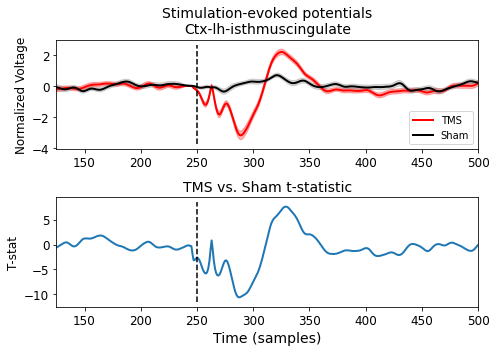

In [13]:
%matplotlib inline

#Average waveforms
sep_tms_mu = np.mean(sep_tms_, 0)
sep_sham_mu = np.mean(sep_sham_, 0)
sep_tms_sem = sem(sep_tms_, axis=0)
sep_sham_sem = sem(sep_sham_, axis=0)

# Plot some SEPs for a given electrode
e = 103
plt.figure(figsize=(7, 5))
ax = plt.subplot(211)
plt.fill_between(x = np.arange(sep_tms_mu[e, :].size), y1=sep_tms_mu[e, :]-sep_tms_sem[e, :], 
                 y2 = sep_tms_mu[e, :]+sep_tms_sem[e, :], color='red', alpha=0.3)  #plot the error bars
plt.fill_between(x = np.arange(sep_sham_mu[e, :].size), y1=sep_sham_mu[e, :]-sep_sham_sem[e, :], 
                 y2 = sep_sham_mu[e, :]+sep_sham_sem[e, :], color='gray', alpha=0.3)
plt.plot(sep_tms_mu[e, :], color='r', linewidth=2, label='TMS');
plt.plot(sep_sham_mu[e, :], color='k', linewidth=2, label='Sham');
plt.vlines([250], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--')
plt.xlim(125,500); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12); plt.ylabel('Normalized Voltage', fontsize=12)
plt.legend(loc=4)
plt.title('Stimulation-evoked potentials\n'+elecs.iloc[e]['DKT_label'], fontsize=14)

ax = plt.subplot(212)
plt.plot(ttest_ind(sep_tms_[:, e, :], sep_sham_[:, e, :], axis=0, equal_var=True)[0], linewidth=2)
plt.vlines([250], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--')
plt.title('TMS vs. Sham t-statistic', fontsize=14); plt.ylabel('T-stat', fontsize=12)
plt.xlim(125,500); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12); plt.xlabel('Time (samples)', fontsize=14)
plt.tight_layout()

## Identify saturated channels

In [14]:
minmax_ts = []
for e in range(sep_tms_.shape[1]):
    t, p = ttest_ind(sep_tms_[:, e, :], sep_sham_[:, e, :], axis=0, equal_var=True)
    t = np.abs(t)
    minmax_ts.append(max(t))
sat_chans = np.where(np.array(minmax_ts)>20)[0]
print('Saturated channels: '+str(sat_chans))

# Better approach is to look for >10 normalized voltage relative to pre-stim period in each trial. 
sat_comb = list(zip(np.where(np.abs(sep_tms_)>10)[0], np.where(np.abs(sep_tms_)>10)[1]))
unique_sat_combs = np.unique([str(f) for f in sat_comb]) # ordered as trial, elec
B = [(int(s.split(', ')[0][1:]), int(s.split(', ')[1][0:-1])) for s in unique_sat_combs] # string thing is a quick hack! 
bad_elecs, cts = np.unique([b[1] for b in B], return_counts=True)
bad_elecs_remove = bad_elecs[cts>(0.1*sep_tms_.shape[0])]

# Consider excluding any electrode with >10% of trials contaminated.
# For others, remove the contaminated trials and continue using the elec

Saturated channels: []


* See subject 416, parietal stim, elec 138, trial 25 for a nice example of an induced theta response
* Subject 416, parietal stim, session 1, elec 115 is artifact-contaminated
* Subject 416, parietal stim, session 1, elec 113 is likely artifact-contaminated
* Subject 416, parietal stim, session 1, elec 108 is possibly artifact-contaminated
* Subject 405, parietal stim, session 0, elec 89, trial (12, 34) is a nice example of an induced theta response
* Subject 423, parietal stim, session 0, elec 179, trial 15 is a nice example of an induced theta response

Effective window size : 0.512 (s)


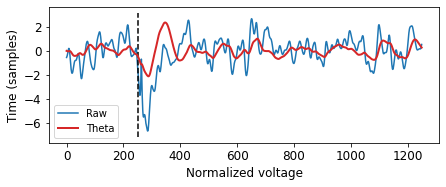

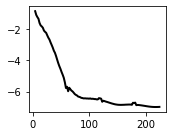

In [20]:
### Example traces
plt.figure(figsize=(7, 2.5))
ax=plt.subplot(111)

trial = 13
X = sep_tms_[trial, e, :]
plt.plot(X,  label='Raw')
plt.vlines([250], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--')

from codebase import butter_bandpass_filter
plt.plot(butter_bandpass_filter(X, 3., 5., fs=fs, order=1), color='C3', linewidth=2, label='Theta')
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.ylabel('Time (samples)', fontsize=12); plt.xlabel('Normalized voltage', fontsize=12)
plt.legend()

#Check power spectrum
from mne.time_frequency import psd_array_welch
psd, freqs = psd_array_welch(sep_tms_[:, e, :], sfreq=fs, fmin=3, fmax=225)
plt.figure(figsize=(2.5, 2)); 
plt.plot(freqs, np.mean(np.log10(psd), 0), linewidth=2, color='k')
plt.tight_layout()

## Get spectral power
Compute multitaper power from the 1.5-second interval following stimulation with 50ms buffer from stimulatione event itself

In [123]:
freqs = [3, 4, 5, 6, 7, 8]  # theta
#freqs = [70, 75, 80, 85, 90, 95] # high gamma
#freqs = [30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50] #gamma
endtime = 2050

#Get the X-second window with a 50ms buffer from stim period -- TMS trials
tfr_tms = mne.time_frequency.tfr_array_multitaper(sep_tms_[:, :, 550:endtime], sfreq=fs, freqs=freqs, output='power',
                                                  n_cycles=4, time_bandwidth=4, n_jobs=n_cpus)
tfr_tms = np.log10(tfr_tms)

# Now for the sham trials
tfr_sham = mne.time_frequency.tfr_array_multitaper(sep_sham_[:, :, 550:endtime], sfreq=fs, freqs=freqs, output='power',
                                                  n_cycles=4, time_bandwidth=4, n_jobs=n_cpus)
tfr_sham = np.log10(tfr_sham)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  96 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 120 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 149 out of 156 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 156 out of 156 | elapsed:    2.4s finished


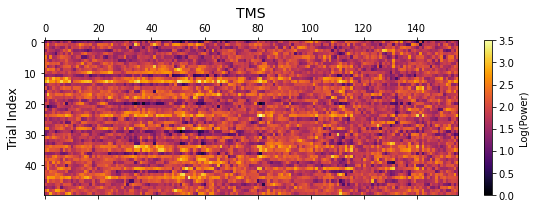

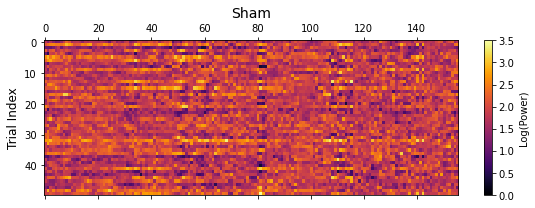

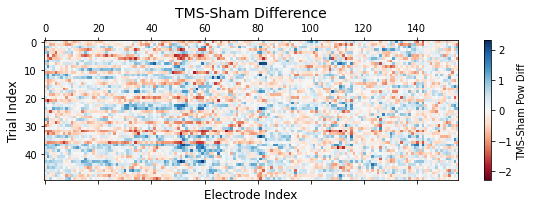

In [140]:
plt.figure(figsize=(8, 3))
plt.matshow(np.mean(np.mean(tfr_tms, -1), -1), cmap='inferno', fignum=0, aspect='auto', vmin=0, vmax=3.5)
plt.ylabel('Trial Index', fontsize=12)
cbar = plt.colorbar(); cbar.set_label('Log(Power)')
plt.title('TMS', fontsize=14)
plt.tight_layout()

plt.figure(figsize=(8, 3))
plt.matshow(np.mean(np.mean(tfr_sham, -1), -1), cmap='inferno', fignum=0, aspect='auto', vmin=0, vmax=3.5)
plt.ylabel('Trial Index', fontsize=12)
cbar = plt.colorbar(); cbar.set_label('Log(Power)')
plt.title('Sham', fontsize=14)
plt.tight_layout()

plt.figure(figsize=(8, 3))
plt.matshow(np.mean(np.mean(tfr_tms, -1), -1)-np.mean(np.mean(tfr_sham, -1), -1), cmap='RdBu', aspect='auto',
           fignum=0, vmin=-2.3, vmax=2.3)
cbar = plt.colorbar(); cbar.set_label('TMS-Sham Pow Diff')
plt.ylabel('Trial Index', fontsize=12)
plt.xlabel('Electrode Index', fontsize=12);
plt.title('TMS-Sham Difference', fontsize=14)
plt.tight_layout()

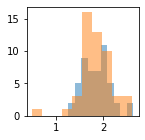

In [117]:
plt.figure(figsize=(2, 2))
plt.hist(np.mean(np.mean(tfr_sham, -1), -1)[:, 141], alpha=0.5);
plt.hist(np.mean(np.mean(tfr_tms, -1), -1)[:, 141], alpha=0.5);

(array([], dtype=int64),)


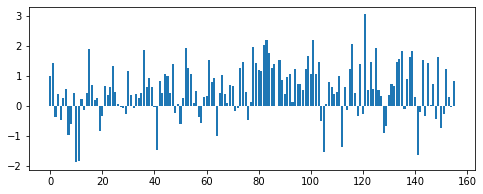

In [122]:
%matplotlib inline

#Plot results
t, p = ttest_ind(np.mean(np.mean(tfr_tms, -1), -1), np.mean(np.mean(tfr_sham, -1), -1), axis=0, equal_var=False)
plt.figure(figsize=(8, 3))
plt.bar(np.arange(t.size), t)

#FDR correction for significance
from mne.stats import fdr_correction
b, p_corr = fdr_correction(p, 0.05, method='indep')
print(np.where(b))